# **DEEP LEARNING**

**UNIVERSIDAD MILITAR NUEVA GRANADA**

**DEEP LEARNING - REGRESIÓN LINEAL DESDE CERO**

Facultad de Ingeniería

# 1. Librerías

In [ ]:
import tensorflow as tf
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 2. Training data (Dataset)

*   50000 examples
*   5 features
*   Normal distribution
*   $\mathbf{X}\in \mathbb{R}^{5000 \times 5}$
*   Ground truth: $\mathbf{w} = [0.1, 0.2, 0.4, 0.8]^\top$, $b = 1.0$
*   Labels: $\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$


In [ ]:
# Generar datos de prueba (y = Xw + b + ruido)
def datos_prueba(w, b, num_ejemplos):
    X = tf.zeros((num_ejemplos, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.1)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [ ]:
w_gen = tf.constant([0.1, 0.2, 0.4, 0.8])
b_gen = 1.0
features, labels = datos_prueba(w_gen, b_gen, 5000)

In [ ]:
features.shape

TensorShape([500, 4])

In [ ]:
# Mostrar ejemplos de features y columnas
#Features: 2 columnas, labels: 1 columna
print('features:', features[0:5],'\nlabel:', labels[0:5])

features: tf.Tensor(
[[ 1.2332774   0.3000318   0.31513986 -0.31656978]
 [-1.094559   -0.28161427  0.89448476  0.00741684]
 [-0.8466014  -1.0172703   0.59692824  1.0646915 ]
 [ 0.41578746 -1.124401   -1.3188621   0.33549097]
 [-1.90419     0.6402444  -1.2754111   0.67573655]], shape=(5, 4), dtype=float32) 
label: tf.Tensor(
[[0.98413134]
 [1.2637483 ]
 [1.805243  ]
 [0.62258255]
 [0.8904207 ]], shape=(5, 1), dtype=float32)


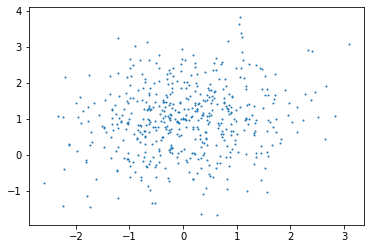

In [ ]:
# Diagrama de dispersión de un feature vs el label
plt.scatter(features[:, (0)].numpy(), labels.numpy(), 1)

# 3. Lectura del dataset por lotes

Aleatorizar y leer por minilotes

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)         # Leer de forma aleatoria los ejemplos
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [ ]:
# Prueba de la lectura por minilotes
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-0.6212379  -1.0847845  -1.0209312  -1.4939622 ]
 [-0.7092744   1.8802336  -0.42178723 -0.57110316]
 [ 0.43603304 -0.51089287  1.312698   -1.4193673 ]
 [ 0.86857116  0.84587765 -1.3597243  -0.72480494]
 [ 0.5283622  -1.6491388  -0.32042903  0.5673555 ]
 [ 1.0566078   0.9827438   2.2938051   1.9775807 ]
 [ 1.5622501   0.45002013 -0.0948767   0.59441924]
 [ 0.74531585 -0.01219221 -0.67552584  1.4576309 ]
 [ 1.0961915   0.6496068  -0.19869201  2.6479034 ]
 [-1.2990075  -1.1332334   0.6127417  -0.26467842]], shape=(10, 4), dtype=float32) 
 tf.Tensor(
[[-0.9773936 ]
 [ 0.50160414]
 [ 0.27324742]
 [ 0.07441816]
 [ 1.1124737 ]
 [ 3.8295367 ]
 [ 1.8415084 ]
 [ 1.819005  ]
 [ 3.2884116 ]
 [ 0.68284416]], shape=(10, 1), dtype=float32)


# 4. Inicialización de parámetros

Prueba inicializando w a partir de una distribución normal de media cero y desviación estándar 0.01, y b en cero

In [ ]:
w = tf.Variable(tf.random.normal(shape=(4, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

w

<tf.Variable 'Variable:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.00461285],
       [-0.01475886],
       [ 0.0104393 ],
       [-0.0054685 ]], dtype=float32)>

# 5. Modelo

Regresión lineal

Producto punto (matriz-vector) de las entradas (features $\mathbf{X}$) con los pesos del modelo ($\mathbf{w}$) más el offset ($b$)

In [ ]:
# Modelo de regresión lineal
def reg_lineal(X, w, b):
    return tf.matmul(X, w) + b

# 6. Función de pérdida

Error cuadrático

In [ ]:
# Pérdida por error cuadrático
def perd_cuad(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

# 7. Algoritmo de optimización

Minibatch stochastic gradient descent

Entradas: conjunto de parámetros, tasa de aprendizaje (learning rate), y el tamaño del lote (batch size)

In [ ]:
def sgd(params, grads, lr, batch_size):
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

# 8. Entrenamiento

* Inicializar parámetros $(\mathbf{w}, b)$
* Repetir
    * Cálculo del gradiente $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Actualizar parámetros $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

En cada épocha (epoch) se itera todo el conjunto de datos

El número de épocas y la tasa de aprendizaje son hiperparámetros  

In [ ]:
# hiperparámetros
lr = 0.03
num_epochs = 10
net = reg_lineal
loss = perd_cuad

In [ ]:
# entrenamiento
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)           # Cálculo de función de pérdida en el minilote
        dw, db = g.gradient(l, [w, b])          # Cálculo del gradiente de la pérdida con respecto a w y b
        sgd([w, b], [dw, db], lr, batch_size)   # Actualizar parámetros utilizando el gradiente
    train_l = loss(net(features, w, b), labels)
    print(f'Época {epoch + 1}, pérdida {float(tf.reduce_mean(train_l)):f}')

Época 1, pérdida 0.052833
Época 2, pérdida 0.007863
Época 3, pérdida 0.005031
Época 4, pérdida 0.004843
Época 5, pérdida 0.004823
Época 6, pérdida 0.004819
Época 7, pérdida 0.004816
Época 8, pérdida 0.004820
Época 9, pérdida 0.004824
Época 10, pérdida 0.004818


In [ ]:
b

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.0109751], dtype=float32)>

Comparación con los parámetros originales

In [ ]:
print(f'Error al estimar w: {w_gen - tf.reshape(w, w_gen.shape)}')
print(f'Error al estimar b: {b_gen - b}')

Error al estimar w: [-0.00136214 -0.00073063 -0.00446239 -0.01013106]
Error al estimar b: [-0.01097512]


# 9. Referencias

Dive into Deep Learning